<a href="https://colab.research.google.com/github/sejin-sim/Practical_statistics/blob/main/3_%ED%86%B5%EA%B3%84%EC%A0%81_%EC%8B%A4%ED%97%98%EA%B3%BC_%EC%9C%A0%EC%9D%98%EC%84%B1%EA%B2%80%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅

In [19]:
! pip install wquantiles 

%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

! git clone https://github.com/gedeck/practical-statistics-for-data-scientists.git
! cp -r /content/practical-statistics-for-data-scientists/data /content/data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

import warnings
warnings.filterwarnings("ignore")

fatal: destination path 'practical-statistics-for-data-scientists' already exists and is not an empty directory.


# 1. A/B 검정

- A/B 검정 : 어느 한 쪽이 다른 쪽보다 더 우월하다는 것을 입증하기 위해 실험군을 두 그룹으로 나누어 진행하는 실험

 ㄴ ex. 두 개의 인터넷 광고를 검정하여 어느 것이 더 높은 전환율을 얻을지 판단한다. (웹 환경에서 많이 사용 됨)

- 처리군 : 특정 처리에 노출된 대상들의 집단
- 대조군 : 어떤 처리도 하지 않은 대상들의 집단

- 검정통계량 : 처리 효과를 측정하기 위한 지표

# 2. 가설검정

- 가설검정(hypothesis test) : 관찰된 효과가 우연인지 평가하기 위해 A/B검정이나 더 나아가 그 외 여러 무작위 실험을 포함하는 분석

- 귀무가설=영가설(null hypothesis) : 그룹 간의 차이는 우연에 의한 결과 (기본 가설)

- 대립가설(alternative hypothesis) : 귀무가설과의 대조(증명하고자 하는 가설)

- 일원검정 : 한 방향으로만 우연히 일어날 확률을 계산하는 가설 검정(ex. B는 A보다 낫다, 한 방향만을 고려해 P값 계산)

- 이원검정 : 양방향으로 우연히 일어날 확률을 계산하는 가설 검정(ex. A는 B와 다르며 더 크거나 더 작을 수 있다. 양쪽을 고려해 P값 계산)

# 3. 재표본추출

- 재표본추출 : 관측 데이터로부터 반복해서 표본추출하는 과정 (부트스트랩, 순열검정)

- 순열검정(permutation test) : 두 개 이상의 표본을 함께 결합하여 관측값들을 무작위로 재표본으로 추출하는 과정
 1. 여러 그룹의 결과를 단일 데이터 집합으로 결합한다.
 2. 결합된 데이터를 잘 섞은 후, 그룹 A와 동일한 크기의 표본을 무작위로(비복원) 추출한다.
 3. 나머지 데이터에서 그룹 B와 동일한 크기의 샘플을 무작위로(비복원) 추출한다.
C, D 등의 그룹에 대해서도 동일한 작업을 수행한다.
 4. 원래 샘플(예를 들면 그룹 비율의 차이)에 대해 구한 통계량 또는 추정치가 무엇이었든 간에 지금 추출한 재표본에 대해 모두 다시 계산하고 기록한다. 
 5. 이것으로 한 번의 순열 반복이 진행된다.
 6. 앞선 단계들을 R번 반복하여 검정통계량의 순열 분포를 얻는다.

 → 관찰된 차이가 대부분의 순열분포 바깥에 있다면, 차이는 통계적으로 유의미하다.

- 예제 : 고가의 서비스를 제공하는 한 회사에서 두 가지 웹 디자인을 두고 판매효과 검증

1. 웹 페이지 A와 B의 세션 시간


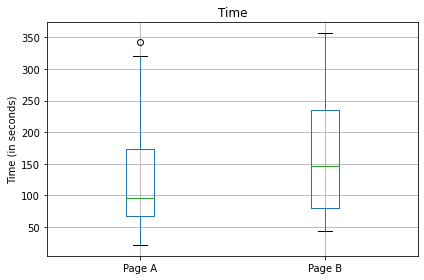

In [20]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(6, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

print("1. 웹 페이지 A와 B의 세션 시간")
plt.tight_layout()
plt.show()

In [21]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


- 페이지 B가 방문객들을 더 오래잡은 것으로 확인 된다.

- B의 시간이 A와 비교하여 35.67초 정도 더 길다.

2. 페이지 A&B 세션 시간 차이에 대한 도수분포


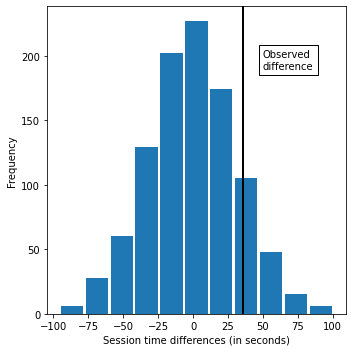

In [22]:
# Permutation test example with stickiness
# 36개의 세션 시간을 그룹에 랜덤하게 할당
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = 21
nB = 15
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

print("2. 페이지 A&B 세션 시간 차이에 대한 도수분포")
plt.tight_layout()
plt.show()

In [23]:
print(np.mean(np.array(perm_diffs) > mean_b - mean_a))

0.121


- 순열검정을 적용하여, 모든 세션 시간을 결합한 다음, 잘 섞은 후 21개의 그룹(nA)과 15개의 그룹(nB)으로 반복하여 표본을 추출한다.

- 점선은 관측된 차이를 보여준다.

- 12.1%의 확률로 무작위 순열로 구한 평균 세션 시간의 차이가 실제 관찰 세션 시간의 차이를 넘어간다. → 차이가 통계적으로 유의미 X

# 4. 통계적 유의성과 p 값

- 통계적 유의성 : 통계학자가 자신의 실험 결과가 우연히 일어난 것인지 아니면 우연히 일어날 수 없는 극단적인 것인지를 판단하는 방법
 
 ㄴ 결과가 우연하게 벌어질 수 있는 변동성의 바깥에 존재한다면 우리는 이것을 통계적으로 유의하다고 한다.

- 예제 : 전사상거래의 실험 결과를 담은 표

|결과|가격A|가격B|합계|
|-------|------|------|------|
|전환|200|182|382|
|전환되지 않음|23,539|22,406|45,945|
|합계|23,739|22,588|46,327|
|전환율|0.8425%|0.8057%|0.8246%|

Observed difference: 0.0368%
1. 가격A와 가격B 사이의 전환율 차이에 대한 도수분포


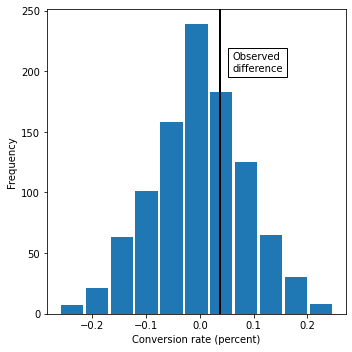

In [24]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')

conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

print("1. 가격A와 가격B 사이의 전환율 차이에 대한 도수분포")
plt.tight_layout()
plt.show()

- 1,000개의 재표본 추출 결과를 봤을 때, 관측된 0.0368%의 차이는 랜덤 변이의 범위 내에 있다.

In [25]:
# 관찰된 차이와 같거나 더 큰 차이라르 보이는 경우의 비율로 p값 추정
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [26]:
# 정규근사법으로 p값 추정
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


- 1종 오류 : 효과가 우연히 발생한 것인데, 사실이라고 잘못 판단하는 경우
- 2종 오류 : 효과가 실제로 있는 것인데, 우연히 발생한 것으로 잘못 판단하는 경우

- p값은 귀무가설로부터 나올 수 있는 결과가 관찰된 결과만큼 극단적으로 나타날 확률이다.
- 유의수준(α)이란, 귀무가설 모델에서 '비정상'이라고 판단할 임계값을 말한다.
- 유의성 검정은 데이터 과학보다는 좀 더 공식적인 연구 보고와 관련이 있다.(그러나 공식적인 연구 보고의 경우에도 최근에는 중요성이 희미해지고 있다)


# 5. t 검정

- t 검정(t-test) : t분포에 기초하며, 널리 사용되는 표준화된 통계량 중 하나
- t 분포(t-distribution) : 관측된 t통계량을 비교할 수 있는, 기준분포
- t 통계량(t-statistic) : 평균과 같이 표준화된 형태의 일반적인 검정 통계량
- 검정통계량(test statistic) : 관심의 차이 또는 효과에 대한 측정 지표
- 예제 : 페이지 A&B 세션 시간 p-value

In [27]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


- 앞서 얻은 순열검정의 p 값 : 0.121

# 6. 다중검정

- 다중 검정(multiple testing) : 여러 개의 가설검정을 동시에 수행하는 것

 ㄴ ex) 증상이 다른 두 환자 집단 간에 유의한 변수들(ex. 유전자 변수들)을 식별하기 위해 유전자의 갯수만큼의 가설을 검정하는 것

- 알파 인플레이션(alpha inflation) : 1종 오류를 만들 확률인 알파가 더 많은 테스트를 수행할 수록 증가하는 다중검정 현상

 → 과대적합(=오버피팅)

- 결론 : 다중성(다중비교, 많은 변수, 많은 모델 등)은 일부가 유의미하다는 결론을 내릴 위험을 증가 시킴 → 통계적 수정 절차가 필요

 → 홀드아웃 표본을 사용하면 이를 피할 수 있다.

# 7. 자유도

- 자유도(d.f.) : 주어진 조건 안에서 통계적인 추정을 할 때에 표본이 되는 자료 중에 모집단에 대한 정보를 주는 독립적인 자료의 수

 ㄴ ex) $ n - 1 $ : 표본크기 n

- 자유도 개념은 회귀를 할 때 다중공선성을 피하기 위해 범주형 변수들을 n-1 지표 혹은 더미 변수로 요인화하는 것의 이유가 된다.

 ㄴ 다중공선성 : 독립변수들 간에 강한 상관관계가 나타나는 문제

# 8. 분산분석

- 분산분석(analysis of variance = ANOVA) : 여러 그룹간의 통계적 유의미한 차이를 검정하는 통계적 절차

- 예제 : 4개의 웹페이지의 방문자가 보낸 시간을 초 단위 평균

0. page별 페이지 점착성 초단위 평균


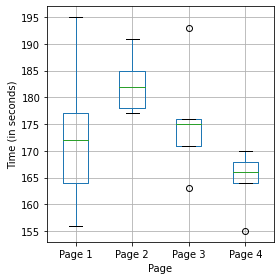

In [35]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

print("0. page별 페이지 점착성 초단위 평균")
plt.tight_layout()
plt.show()

- 총괄검정(여러 그룹 평균들의 전체 분산에 관한 단일 가설검정)의 결과

In [37]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('1. 총괄(순열) 검정')
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

random.seed(1)

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

1. 총괄(순열) 검정
Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.087


- 그룹 간 전체적인 편차가 우연히 발생할 수 있는 범위 내에 있는지를 평가

- p value(=8.13%) > 5% → 페이지간의 차이가 우연히 발행할 수 있다는 결론

In [39]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print("2. F통계량 기반_anova_lm(회귀 분석)")
print(aov_table)

res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)

print('\n3. F통계량 기반_f_oneway(일원 분산 분석)')
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

2. F통계량 기반_anova_lm(회귀 분석)
            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN

3. F통계량 기반_f_oneway(일원 분산 분석)
F-Statistic: 1.3699
p-value: 0.0388


- F 통계량(F-statistic): 그룹 평균 간의 차이가 랜덤 모델에서 예상되는 것보다 벗어나는 정도를 측정하는 표준화된 통계량

- df : 자유도, sum_sq : 제곱합, mean_sq : 평균제곱, F : F통계량

# 9. 카이제곱검정

- 카이제곱검정(chi-square test) : 관찰된 빈도가 기대되는 빈도와 의미있게 다른지의 여부를 검정

- ## $R = 피어슨 잔차 = \frac{관측값 - 기댓값}{\sqrt{기댓값}}$

- ## $X = 카이제곱통계량 = \sum_{i}^{r}\sum_{j}^{c}R^2$

 - 기댓값으로부터 어떤 관찰값까지의 거리를 나타내는 측정치
 - $r, c$: 행, 열의 수

- 기댓값(expectation(expected)): 어떤 가정(보통 귀무가설)으로부터 데이터가 발생할 때, 그에 대해 기대하는 정도

- 피셔의 정확검정(Fisher's exact test): 사건 발생 횟수가 매우 낮을 때, 재표본추출 방법을 통해 더 정확한 p 값을 얻는 검정


In [41]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print("1. 3가지 헤드라인에 대한 웹 테스트 결과")
print(clicks)

1. 3가지 헤드라인에 대한 웹 테스트 결과
Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [42]:
# Table 3-5
row_average = clicks.mean(axis=1)
print("2. 3가지 헤드라인 같은 클릭률 가정시 기댓값")
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

2. 3가지 헤드라인 같은 클릭률 가정시 기댓값


,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


- 귀무가설 : 헤드라인 모두가 동일한 클릭률을 갖는다는 가정
- 클릭률 : 34/3000
- 비클릭률 : 1 - 비클릭률

In [55]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)

print('3. 카이제곱통계량 = 피어슨 잔차들의 제곱합')
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

3. 카이제곱통계량 = 피어슨 잔차들의 제곱합
Observed chi2: 1.6659
p-value: 0.4348


4. 표준 카이제곱분포


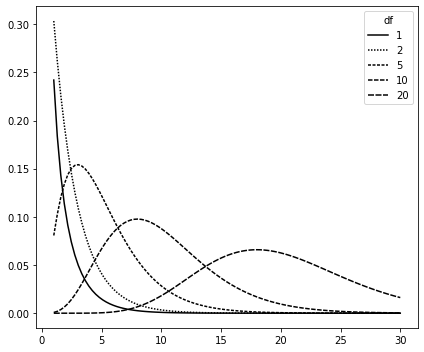

In [88]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

print("4. 표준 카이제곱분포")
plt.tight_layout()
plt.show()

# 10. 멀티암드 밴딧 알고리즘(MAD)

- 전통적 A/B 검정은 임의표집 과정을 기본으로 하기 때문에, 수익이 낮은 것을 너무 많이 시도할 수 있다.

 → MAB는 실험 도중에 얻는 정보를 통합하고 수익이 낮은 것의 빈도를 줄이는 쪽으로 표본 추출 과정을 변경한다.

- 멀티암드 밴딧(MAB) : 고객이 선택할 수 있는 손잡이가 여러 개인 가상의 슬롯머신을 말하며, 각 손잡이는 각기 다른 수익을 가져다 준다. 다중 처리 실험에 대한 비유라고 생각할 수 있다.

<br> 

- 전략 1. 그리디 알고리즘(greedy algorithm)

 → 한 번씩 플레이 한 후 점수 좋은 슬롯 머신에 몰빵 (= 엡실론 0)


- 전략 2. 엡실론-그리디 알고리즘(epsilon-greedy algorithm)

 → 동전을 던져서 윗면이 나오면 점수 좋았던 슬롯머신, 뒷면이 나오면 랜덤으로 선택
 
 - 과정
 1. 0부터 1 사이의 난수를 생성한다.
 2. 이 숫자가 0과 엡실론(0과 1 사이의 값으로 일반적으로 아주 작다) 사이에 존재하면, 50/50 확률로 동전 뒤집기를 시행한다.

   1. 그 결과 동전이 앞면이면 제안 A를 표시한다.
   2. 동전이 뒷면이면 제안 B를 표시한다.
 3. 숫자가 엡실론보다 크면, 지금까지 가장 좋은 결과를 보인 제안을 표시한다.

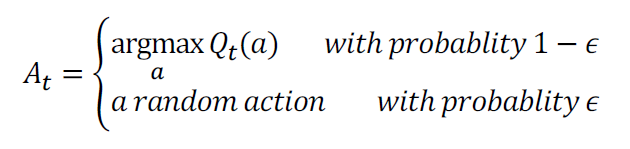
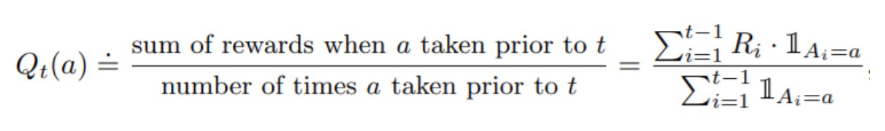

- 전략 3. 톰슨의 샘플링(Thompson's sampling) 알고리즘

 → 베타 분포를 활용한 확률적 알고리즘

 1. 베이지언 방식을 사용. 즉 베타 분포(beta distribution)(베이지언 문제에서 사전 정보를 지정하는 일반적인 메커니즘)를 사용하여 수익의 일부 사전 분포를 가정한다.
 2. 각 추출 정보가 누적되면서 정보가 업데이트되기 때문에, 다음번에 최고 손잡이를 선택할 확률을 효과적으로 최적화할 수 있다.

 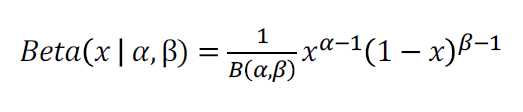

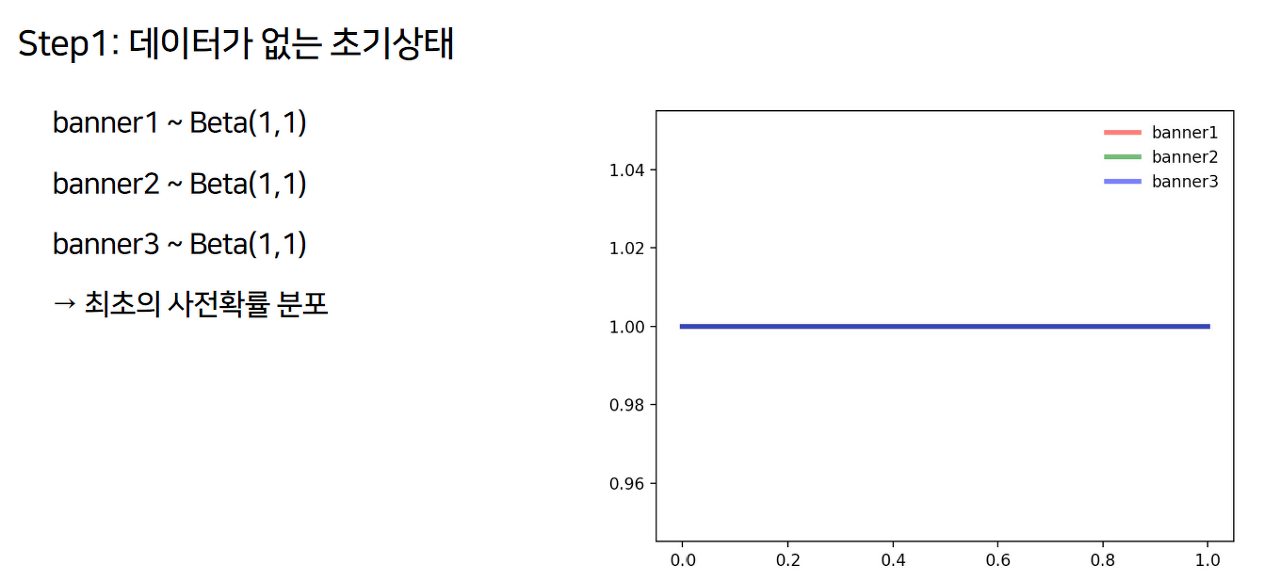

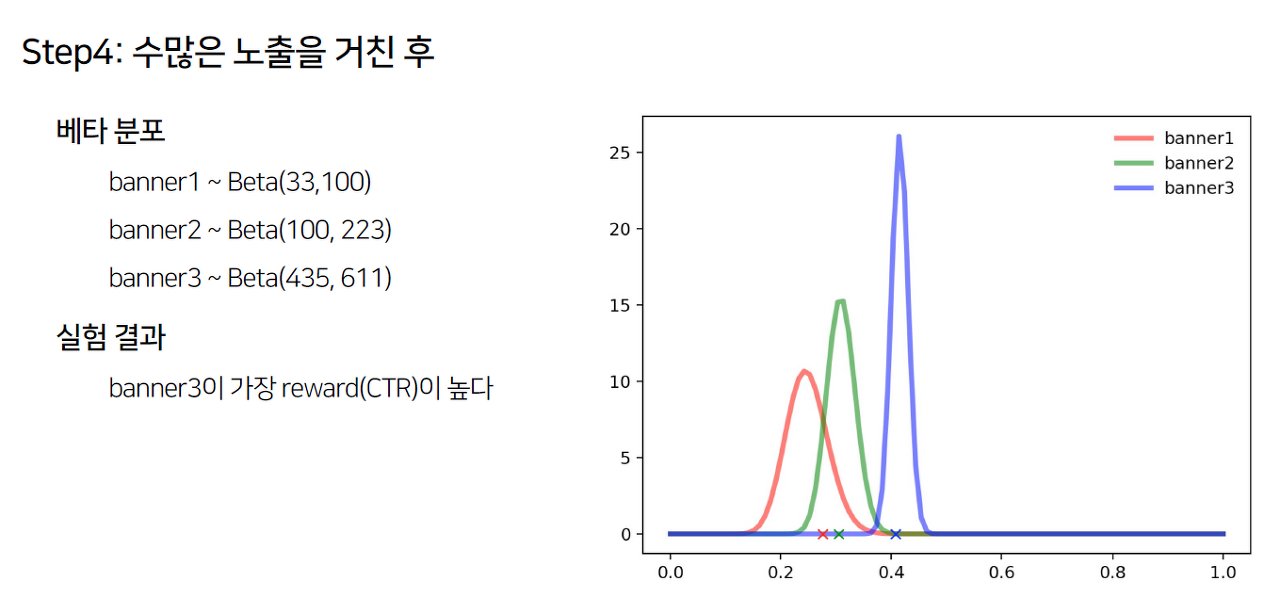

- 전략 4. UCB(Upper-Confidence-Bound)

 → 좋은 수익률을 보이며, 최적의 선택이 될 가능성이 있는 슬롯머신을 선택

 - 현재 해당 action이 최적의 action일 수도 있는 불확실성을 고려하여 최적의 action을 선택하는 알고리즘

 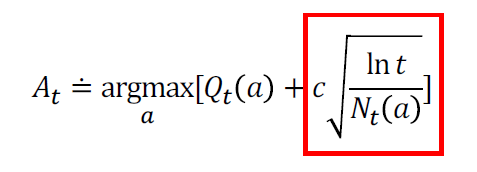


# 11. 검정력과 표본크기

- 웹테스트를 수행할 경우 실행 시간은 어떻게 결정할까?

 → 검정력이란 특정 표본 조건(크기와 변이)에서 특정한 효과크기를 알아낼 수 있는 확률을 의미

- 효과크기 : 통계 검정을 통해 판단할 수 있는 효과의 최소 크기

- 검정력 : 주어진 표본크기로 주어진 효과크기를 알아낼 확률

In [94]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


- 80%의 검정력을 원하면 116,602.393번 정도를 실행 해야 한다.

In [95]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


- ph1(=효과 크기)를 0.0121 → 0.0165로 증가시킬 경우 표본크기는 5,500번 정도로 줄어든다.